# Objetivo deste caderno:
- Obter uma lista de cada um dos palestrantes
- Salvar em uma tabela de excel o nome e a data da palestra, se houver
- No Excel, por fora, vou preencher data de nascimento e sexo

## Obter uma lista de cada um dos palestrantes


Antes de realizar o préprocessamento pelo Python,eu alterei o nome de uma das pastas em sph em stm de 'Halla_Tomasdottir' para "HallaTomasdottir". Como era uma única observação, optei pela alteração manual.

In [33]:
import os
import re
import numpy as np
import pandas as pd
import requests
import json
import time

In [2]:
test_sph=os.listdir('TEDLIUM_release1/test/sph/')
test_sph=[x[:-4] for x in test_sph]

test_stm=os.listdir('TEDLIUM_release1/test/stm/')
test_stm=[x[:-4] for x in test_stm]

train_sph=os.listdir('TEDLIUM_release1/train/sph/')
train_sph=[x[:-4] for x in train_sph]

train_stm=os.listdir('TEDLIUM_release1/train/stm/')
train_stm=[x[:-4] for x in train_stm]

In [3]:
train_sph==train_stm

True

In [4]:
test_sph==test_stm

True

In [5]:
nome_ano_test=[i.split('_') for i in test_sph]
for i in nome_ano_test:
    i.append('Test')
nome_ano_train=[i.split('_') for i in train_sph]
for i in nome_ano_train:
    i.append('Train')

In [6]:
test=pd.DataFrame(nome_ano_test,columns=['Nome','Ano','Set'])
train=pd.DataFrame(nome_ano_train,columns=['Nome','Ano','Set'])

In [7]:
def sep_nome(nome):
    for i in np.unique(re.findall('[A-Z]',nome)):
        nome=nome.replace(i,' '+i)
    return nome

In [8]:
test.Nome=test.Nome.apply(lambda x: sep_nome(x)).str.lstrip()
test.Ano=test.Ano.apply(lambda x:re.sub('[^0-9]','',x))

In [9]:
train.Nome=train.Nome.apply(lambda x: sep_nome(x)).str.lstrip()
train.Ano=train.Ano.apply(lambda x:re.sub('[^0-9]','',x))

In [10]:
tabela=train.append(test)

#### pré-processamento extra
Algumas palestras da base são números musicais ou têm dois palestrantes. Quando tem 2 palestrantes ou um grupo, temos 4 palavras(NOME1 SOBRENOME1 NOME2 SOBRENOME2) e quando é um número musical, todas as letras do nome da música estão maiúsculas. Como eu adicionei um espaço antes de todas letras maiúsculas, só preciso contar o número de espaços no nome para filtrar. 

In [11]:
tabela.Nome[tabela.Nome.str.count(' ')==2].sample(5)

715    Teresa Carreno Orchestra
77                Bruce Mc Call
730             Tim Berners Lee
7               Jane Mc Gonigal
765        Yann Arthus Bertrand
Name: Nome, dtype: object

In [12]:
tabela.Nome[tabela.Nome.str.count(' ')==3].sample(5)

287             His Holiness The Karmapa
717                            The L X D
632       Rufus Griscomand Alisa Volkman
52     Beverly Joubertand Dereck Joubert
720                 They Might Be Giants
Name: Nome, dtype: object

In [13]:
tabela.Nome[tabela.Nome.str.count(' ')>3].sample(5)

341               Jill Sobuleand Julia Sweeney S H O W
489                   Murray Gell Mann L A N G U A G E
342    Jill Sobule M A N H A T T A N I N J A N U A R Y
585                       Raul Midon E V E R Y B O D Y
753                 Vusi Mahlasela S O N G O F M A M A
Name: Nome, dtype: object

In [14]:
train.shape,test.shape,tabela.shape

((774, 3), (11, 3), (785, 3))

In [15]:
tabela=tabela[tabela.Nome.str.count(' ')<3]

### Adicionar coluna de sexo

In [16]:
tabela['Sexo']=''

## Descobrir sexo via API

In [23]:
tabela['Primo Nome']=tabela.Nome.str.split(' ',expand=True)[0]#.unique()

In [27]:
decoder=json.JSONDecoder()

In [30]:
nomes=tabela['Primo Nome'].unique()

In [31]:
dicio_nomes={}

In [37]:
len(nomes)

416

In [40]:
for n in nomes:
    dicio_nomes[n]=decoder.decode(requests.get('https://api.genderize.io/?name='+n.lower()).text)
    time.sleep(1) # para não dar pau

In [44]:
probs=pd.DataFrame(dicio_nomes).T

In [48]:
probs.gender=probs.gender.replace({'male':'M','female':'F'})

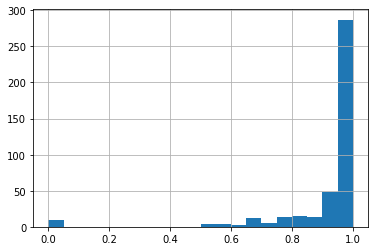

In [56]:
probs['probability'].hist(bins=20)

In [57]:
probs[probs.probability<0.99][probs.probability>0.95]

<ipython-input-57-67ce9bc675d6>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  probs[probs.probability<0.99][probs.probability>0.95]


,name,gender,probability,count
Adam,adam,M,0.98,116396
Aditi,aditi,F,0.97,341
Aimee,aimee,F,0.97,2868
Alison,alison,F,0.98,25555
Anil,anil,M,0.97,6560
...,...,...,...,...
Wade,wade,M,0.96,1695
Will,will,M,0.97,15251
Yann,yann,M,0.98,28202
Yves,yves,M,0.98,27837


In [66]:
probs['vals']=np.where(probs.probability>0.95,probs.gender,'')

In [74]:
tabela['Sexo']=tabela['Primo Nome'].map(dict(probs.vals))

## Salvar em uma tabela de excel o nome e a data da palestra, se houver

In [76]:
tabela.to_excel('Registro_Palestrantes.xlsx')

## No Excel, por fora, vou preencher o resto do sexo